# Tarefa 3 -  Análise de Convexidade e Implementação de GD, SGD em Regressão Logística Binária e Multinomial

Aluno: Tomás Aguiar Carneiro Ferreira

RA: 177748

# Resumo

Como a rotina a seguir está bem longa, decidi iniciar com um resumo do documento como um todo.

Iniciamos com uma análise de convexidade, utilizando a função quadrática proposta pela Tarefa. Para uma quadrática bi-dimensional, mostramos visualmente a natureza dos pontos críticos/estacionários referentes aos $3$ casos de convexidade exigidos através de plots $\text{3D}$ simples. Após isso, implementamos o Gradiente Descendente ($\text{GD}$) e Gradiente Descendente Estocástico para uma quadrática $n$-dimensional. Na nossa análise subsequente, foram plotados gráficos de iterações por dimensão da quadrática e valor da função objetiva por iteração. Para o $\text{SGD}$, incluímos um gráfico adicional do número de iterações variando-se of fator de amplificação da taxa de aprendizado ($\gamma$).

Em seguida, implementamos o algoritmo de regressão logísitca binária: apesar de não ter sido pedido pela Tarefa, esta implementação ajudou a entender como implementar a regressão multinomial a qual é a sua generalização natural. No caso, treinamos este algoritmo a identificar o dígito $3$ e obtivemos acurácias razoáveis (na rotina, deixei publicada a versão com a maior acurácia de acerto$\sim 89.3\%$). Esta implementação foi feita somente para o $\text{GD}$.

Por fim, implementamos o algoritmo de regressão logística multinomial e publicamos somente a versão (heurística) final: conforme pedido pela Tarefa, implementamos esta utilizando $\text{GD}$ e $\text{SGD}$, mas em função dos resultados que fomos observando no decorrer dos testes de implementação, foram feitas duas alterações sobre implementações convencionais de $\text{GD}$ e $\text{SGD}$:

1. Inclusão de um <b>fator de amplificação da taxa de aprendizado</b> em direções onde a função softmax possuía baixa probabilidade de acerto.
2. Inclusão de um <b>fator de atenuamento condicional da taxa de aprendizado</b>. Isto é, caso a função objetiva de um passo seguinte aumente o valor da função objetiva, a rotina fica presa num loop o qual reduz a taxa de aprendizado por um fator de $0.9$ até a função objetiva voltar a reduzir. Este loop pode ocorrer no máximo $100$ vezes.

O motivo específico por trás destas inclusões estão explicados mais detalhadamente no cabeçalho da respectiva seção. Em todas as seções, exploramos em detalhes a matemática por trás de cada implementação. A qualidade do código foi melhorando ao longo da Tarefa (finalmente aprendi a utilizar sintaxe mais vetorizada). Várias das terminologias e estratégias de implementação que fui aprendendendo no decorrer da escrita foram retirados das aulas do curso de Machine Learning do <i>Herman Kamper</i> (link: https://www.kamperh.com/data414/).

In [1]:
import random
from functools import lru_cache
import os
import math
import mpmath as mp
from scipy.spatial import distance
from sklearn.impute import SimpleImputer

#Função que será utilizada para embaralhar os dados, caso necessário
from sklearn.utils import shuffle 

#Função que utilizaremos para cálculo de média
from sklearn.preprocessing import StandardScaler

import time
import numpy as np
import pandas as pd
import jax.numpy as jnp
from matplotlib import pyplot as plt
#import tensorflow as tf
#from tensorflow import keras

import sklearn.preprocessing
from sklearn.preprocessing import LabelEncoder

# 1. Preparo dos Dados

A base de dados do MNIST consiste em $60000$ imagens de números de $0$ a $9$. Estas imagens estão armazenadas em matrizes $28 \times 28$, cada uma representando pixels cujo valor varia de $0$ a $255$, este valor representando a intensidade do traçado do número: $0$ representa 'branco' ou 'ausência de traçado'; e $255$ representa 'preto', ou 'traçado forte'.

Por algum motivo, não foi possível baixar os dados diretamente do site do Yann LeCun, então estes foram baixados pelo kaggle, através do link: https://www.kaggle.com/datasets/hojjatk/mnist-dataset. Os dados foram então extraídos na mesma pasta do notebook jupyter, o que é necessário para que o código abaixo funcione.

Além disso, para a leitura dos dados, é necessário instalar o módulo 'idx2numpy' através do terminal do python, utilizando o comando 'pip install idx2numpy'.

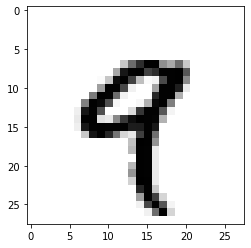

In [2]:
import idx2numpy

# Exemplo de dados de treino
imagefile = 'train-images.idx3-ubyte'
imagearray = idx2numpy.convert_from_file(imagefile)

plt.imshow(imagearray[4], cmap=plt.cm.binary)
print()

In [3]:
print('Número de dados, posto das matrizes:', len(imagearray),',',len(imagearray[0]))
print('Valores únicos:', np.unique(imagearray))

Número de dados, posto das matrizes: 60000 , 28
Valores únicos: [  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35
  36  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53
  54  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71
  72  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89
  90  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107
 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125
 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143
 144 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161
 162 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179
 180 181 182 183 184 185 186 187 188 189 190 191 192 193 194 195 196 197
 198 199 200 201 202 203 204 205 206 207 208 209 210 211 212 213 214 215
 216 217 218 219 220 221 222 223 224 225 226 227 228 229 230

In [4]:
# Exemplo de dados de treino
labelfile = 'train-labels.idx1-ubyte';

labelarray = idx2numpy.convert_from_file(labelfile);

print(labelarray[4])
print('Número de dados:', len(labelarray))
print('Valores únicos:', np.unique(labelarray))

9
Número de dados: 60000
Valores únicos: [0 1 2 3 4 5 6 7 8 9]


In [5]:
imagefile10k = 't10k-images.idx3-ubyte'
imagearray10k = idx2numpy.convert_from_file(imagefile10k)

print('Número de dados:', len(imagearray10k))

Número de dados: 10000


## 1.1. Transformando as matrizes-imagem em vetores

Ao todo, a base de dados possui 2 arquivos de treino. A única diferença entre estes está no número de dados. Isto é, todos os dados indicados por '$\text{idx3}$' estão associados à base completa de treino/teste ($60000$ dados) e os indicados por '$\text{idx1}$' estão associados à base reduzida de dados. Para a nossa análise, iremos utilizar somente a base completa. Além disso, dividimos todas as entradas das matrizes pelo valor máximo $255$ para que os dados estejam contidos no intervalo $[0,1]$. Isso ajuda a estabilizar a inicialização e convergência dos dados no estágio de implementação.

In [6]:
# Dados totais
data_img = 'train-images.idx3-ubyte'
data_labels = 'train-labels.idx1-ubyte'

data_img_arr = idx2numpy.convert_from_file(data_img)/255
data_labels_arr = idx2numpy.convert_from_file(data_labels)

Para o treino do algoritmo de regressão logística, precisamos converter as matrizes-imagem em listas de datapoints. No caso, vamos considerar cada pixel da imagem como uma feature, transformando a matriz imagem num datapoint de $28 \times 28 = 784$ features. 

In [7]:
data_vec = [[column for column in range(784)] for row in range(len(data_img_arr))]
print(len(data_vec[0]),len(data_vec))

784 60000


In [8]:
start = time.perf_counter()
i = 0;
# Iteração sobre os dados
while i < len(data_vec):
    j = 0;
    # Iteração sobre as 28 linhas-pixel da i-ésima imagem
    while j < 28:
        k = 0;
        # Iteração sobre as 28 colunas-pixel da i-ésima imagem
        # Para cada linha iterada, adicionamos 28 ao índice da forma vetorizada dos dados
        while k < 28:
            data_vec[i][j*28+k]=data_img_arr[i][j][k]
            k+=1;
        j +=1;
    i+=1;
end = time.perf_counter()
print(end-start)

38.63573870000005


## 1.2. Separando os dados, dígito a dígito

No dataset, temos $10$ dígitos, de $0$ a $9$. Para treinar a regressão multinomial, teremos que separar os dados de treino em termos dos dígitos. Portanto, vamos separar a base de dados, armazenando os dados referentes a cada dígito na entrada correspondente (entrada $0$ do vetor corresponde ao dígito $0$, entrada $1$ ao dígito $1$, etc).

In [9]:
# Cria lista de 10 entradas, onde armazenaremos os dados de cada dígito
data_digits = list()

# Separação de dados por dígito
i = 0;
while i < 10:
    digit_buff = list()
    j=0;
    while j < len(data_vec):
        # Identifica se a o dígito da entrada atual corresponde a i
        if data_labels_arr[j] == i:
            digit_buff.append(data_vec[j])
        j+=1;

    # Armazena os dados referentes a um dado dígito na lista
    data_digits.append(digit_buff);
    i+=1;

In [10]:
# Número de amostras de cada dígito
i = 0
while i < len(data_digits):
    print(len(data_digits[i]))
    i+=1

5923
6742
5958
6131
5842
5421
5918
6265
5851
5949


Como podemos ver, o número de dados relacionados a cada dígito são diferentes. Para que o treino da regressão multinomial não tenha um bias para algum dígito em particular, identificamos o dígito com menor número de amostras e copiamos o número de amostras para todos os outros.

In [11]:
# Encontra o dígito com menor número de amostras
digit_size = [len(y) for y in data_digits];
min_digit = min([x for x in digit_size]);
print(min_digit, digit_size.index(5421))

5421 5


In [12]:
# Gera as amostras aleatória de mesmo tamanho daquela do dígito 5
data_digits_h = [random.sample(x, min_digit) for x in data_digits];
new_digit_size = [len(y) for y in data_digits_h];
print(new_digit_size)

[5421, 5421, 5421, 5421, 5421, 5421, 5421, 5421, 5421, 5421]


## 1.3. Divisão de dados de treino e teste

Utilizando a base MNIST, vamos implementar tanto a Regressão Logística Binária quanto a Regressão Logística Multinomial. Para cada uma destas implementações, vamos preparar dados de treino e teste. A proporção entre estes será de $2 : 1$, ou seja, $67\%$ para treino e $33\%$ para teste. No caso da Regressão Logística Binária, queremos gerar dados de treino que sejam aproximadamente $50\%$ resultados positivos e $50\%$ resultados negativos. No caso da Regressão Logística Multinomial, vamos utilizar o $\text{data}\_\text{digits}\_\text{h}$ que preparamos ao fim da subseção anterior, onde temos exatamente $10\%$ de cada dígito.

### Regressão Binária

Para a regressão binária, queremos que os nossos dados positivos e negativos tenham o mesmo tamanho e que os dados negativos estejam homogeneamente distribuídos em termos dos outros dígitos. Para isso, as únicas restrições sobre o número total de datapoints negativos é que seja um múltiplo de $3\times 9=27$, visto que temos $9$ dígitos que deverão dar resultado negativo e que cada dígito deverá ser dividido na proporção $2:1$ para teste. O maior número menor do que $5421$ que satisfaz essas condições é o número $5400$. Assim, a lista de resultados negativos será formada por $600$ datapoints de cada dígito diferente de $3$, os quais serão divididos em $400$ de treino e $200$ de teste cada.

In [13]:
# Tamanho dos dados pos/neg
bin_size = 5400;
bin_train_size = 2700;
bin_test_size = 1800;

# Listas de treino/teste positivas
bin_pos = random.sample(data_digits_h[3], bin_size);
bin_pos_tuples = [ (x,1) for x in bin_pos];
bin_pos_train = bin_pos_tuples[:bin_train_size];
bin_pos_test =  bin_pos_tuples[-bin_test_size:];

# Listas de treino/teste negativas
filter_samples = data_digits_h[:2] + data_digits_h[-7:]; # Seleciona somente os dígitos diferentes de 3
bin_neg_sep = [random.sample(x,600) for x in filter_samples];

# Transforma lista filtrada numa lista só com todas as amostras
bin_neg = np.concatenate(bin_neg_sep).tolist()

# Monta as tuplas de resultados negativos
bin_neg_tuples = [(x,0) for x in bin_neg]
bin_neg_train = bin_neg_tuples[:bin_train_size];
bin_neg_test =  bin_neg_tuples[-bin_test_size:];

# Tuplas de teste/treino
bin_train_tuples = bin_pos_train + bin_neg_train;
bin_train_tuples = shuffle(bin_train_tuples);
bin_test_tuples = bin_pos_test + bin_neg_test;
bin_test_tuples = shuffle(bin_test_tuples)

# Separação em atributos e targets
bin_X = [x[0] for x in bin_train_tuples];
bin_y = [x[1] for x in bin_train_tuples];
bin_Xtest = [x[0] for x in bin_test_tuples];
bin_ytest = [x[1] for x in bin_test_tuples];

In [14]:
print(len(bin_X),len(bin_X[0]))

5400 784


### Regressão Multinomial

Para a regressão multinomial, teremos $5421$ dados para cada dígito. Ou seja, teremos $3614$ dados de treino e $1807$ de teste para cada dígito. Como a função softmax possui $10$ entradas, os targets serão vetores da forma: $[0,1,0,0,0,0,0,0,0,0]^T$, onde entendemos que o índice $1$ identifica que a imagem possui o dígito $1$.

Vale notar que, durante a implementação, usar a base completa levou a travamento da rotina devido ao enorme número de dados. Por este motivo, a base de dados utilizada foi reduzida mais à frente. Aqui deixamos ela completa.

In [15]:
# Cria matriz cujas entradas tem exatamente a forma necessária
def indicator(size):
    return [[1 if i == j else 0 for j in range(size)] for i in range(size)]
Y_bool = indicator(10);

# Tamanho dos dados
nom_size = 5421;
nom_train_size = 3614;
nom_test_size = 1807;

# Criação de tuplas (dígito, target) para todos os dados
nom_tuples = [[(x,v) for x in u] for (u,v) in zip(data_digits_h ,Y_bool)];

# Criação de dados de treino e teste para cada dígito
start = time.perf_counter();
nested_X_tuples = [x[:nom_train_size] for x in nom_tuples];
nom_X_tuples = [inner for outer in nested_X_tuples for inner in outer];
nom_X_tuples = shuffle(nom_X_tuples);
nom_X = [x[0] for x in nom_X_tuples];
nom_y = [x[1] for x in nom_X_tuples];

nested_Xtest_tuples = [x[-nom_test_size:] for x in nom_tuples];
nom_Xtest_tuples = [inner for outer in nested_Xtest_tuples for inner in outer];
nom_Xtest_tuples = shuffle(nom_Xtest_tuples);
nom_Xtest = [x[0] for x in nom_Xtest_tuples];
nom_ytest = [x[1] for x in nom_Xtest_tuples];
end = time.perf_counter();

print(len(nom_X),len(nom_y))
print(len(nom_Xtest),len(nom_ytest))
print(end-start)

36140 36140
18070 18070
0.02931059999991703


Com isto, podemos prosseguir para a fase de implementação e análise.

# 2. Análise de Convexidade

De gorma geral, o tópico de otimização consiste em problemas onde queremos encontrar o máximo/mínimo de uma função. Em matérias de Cálculo I, isso pode parecer uma tarefa trivial, basta encontrar o argumento tal que tal que a sua primeira derivada é nula. No entanto, os problemas abordados em otimização dificilmente dependerão de um ou dois parâmetros: queremos tratar de métodos que consigam solucionar - de forma computacionalmente tractável - problemas onde a função que queremos minimizar possui milhares ou até milhões de argumentos.

Evidentemente, existem inúmeros métodos associados a inúmeras classes de problemas de otimização diferentes, e visto que não é uma área de profundo conhecimento meu, centrarei minha atenção em dois exemplos da chamada <i>função objetivo</i>.

## Otimização e Função Objetivo

A <b>função objetivo</b> é justamente a função $f(\boldsymbol{x})$ que queremos minimizar/maximizar no problema de otimização. Matematicamente, queremos encontrar o vetor $\boldsymbol{x}=\boldsymbol{x^*}$ tal que $f(\boldsymbol{x^*})<f(\boldsymbol{x}),\; \forall \;  \boldsymbol{x} \neq \boldsymbol{x^*}\in \mathcal{D}$, onde $\mathcal{D}$ é o domínio da função $f$. 

O significado desta minimização depende do problema. Por exemplo, o problema central tratado na Tarefa consiste em treinar um algoritmo para identificar dígitos de $0$ a $9$ desenhados à mão. Para solucionar esta implementação, o problema se reduzirá a determinar a distribuição de probabilidade mais provável que representa os dados, a qual pode ser obtida através da minimização do <b>log negativo da função de verossimilhança</b> (ou <b>negative log likelihood</b>). 

\begin{align*}
    l(\boldsymbol{W})=-\sum_{i=1}^N \log  L(\boldsymbol{W})
\end{align*}
\begin{align*}
    L(\boldsymbol{W})=\prod_{i=1}^N p\left(y_{i}|\boldsymbol{x}_i;\boldsymbol{W}\right)
\end{align*}
Onde $p$ é a probabilidade condicional de obter o resultado $y_i$ relativo ao datapoint $\boldsymbol{x}_i$ e como função dos parâmetros $\boldsymbol{W}$. A meta da Tarefa será encontrar o conjunto de parâmetros que otimizam o fit acima. Por enquanto, inicaremos nossa analise de convexidade para uma função objetivo quadrática.

## Convexidade e a Função Objetivo Quadrática

Dependendo da forma da função objetivo, o problema de otimização pode ser muito trabalhoso. De fato, existem determinadas propriedades que são desejáveis para funções objetivo, e as quais diretamente afetam a taxa de convergência do algoritmo de otimização. Iniciamos, portanto, o estudo de funções <b>convexas</b>.

Da forma mais geral possível, uma função convexa $f$ é aquela que respeita a seguinte desigualdade:

\begin{align*}
    f(\alpha\boldsymbol{x}+(1-\alpha)\boldsymbol{y})\leq \alpha f(\boldsymbol{x})+(1-\alpha)f(\boldsymbol{y})
\end{align*}


Geometricamente, o lado direito da equação acima representa a reta que passa pelos pontos $f(\boldsymbol{x})$ e $f(\boldsymbol{y})$, e portanto podemos interpretar essa desigualdade como <i>a reta definida entre quaisquer dois pontos de uma função convexa está 'acima' da função</i>. Só por completeza, o conjunto de todos os pontos 'acima' da função é denominado a <b>epígrafe da função $f(\boldsymbol{x})$</b> ($\text{Epi}(f)$). 

Apesar de ser uma definição abrangente, é mais útil para nós entendermos como essa definição resulta em propriedades diferenciais interessantes para a solução de problemas de otimização e, também, se existe alguma forma de determinar a convexidade de $f$ sem precisarmos aplicar a desigualdade acima.

Do livro-texto, uma das condições suficientes para identificar se a função $f$ é convexa é a <b>condição de segunda-ordem</b>: se a função $f$ é duas vezes continuamente diferenciável no seu domínio e a sua respectiva matriz Hessiana é positiva semi-definida (possui somente autovalores não-negativos), a função $f$ é convexa. Agora, se os autovalores da matriz Hessiana forem todos positivos, então a função $f$ será <b>fortemente convexa</b>.

Para ilustrar os três tipos de funções pedidos pela tarefa, faremos uso de uma função objetivo quadrática:

\begin{align*}
   &f(\boldsymbol{x})=\boldsymbol{x}^T \boldsymbol{A}\boldsymbol{x}+\boldsymbol{b}^T\boldsymbol{x}+c
\end{align*}

Além disso, para simplificar a visualização da nossa análise, consideraremos que esta função depende de somente dois argumentos conforme a equação abaixo.

\begin{align*}
       &f(x,y)=\begin{bmatrix}
       x & y
   \end{bmatrix} \begin{bmatrix}
       A_{11} & A_{12}\\
       A_{21} & A_{22}
   \end{bmatrix}\begin{bmatrix}
       x \\ y
   \end{bmatrix}+\begin{bmatrix}
       b_1 & b_2
   \end{bmatrix}\begin{bmatrix}
       x\\ y
   \end{bmatrix}+c
\end{align*}

Para análise conceitual de convexidade de funções quadráticas, pouco nos interessa a constante $c$ (pois na representação $3D$,  só altera a posição $z$ do mínimo/ponto de sela); as constantes $b_1$, $b_2$ (pois só alteram a coordenada $(x,y)$ do mínimo/ponto de sela); e as constantes $A_{12},A_{21}$ (pois só alteram o ângulo entre os autovetores e os eixos cartesianos). Isto é, toda a análise de convexidade pode ser completamente entendida através da função quadrática diagonalizada, centrada na origem. Além disso, adotaremos a convenção do livro-texto, em que o maior autovalor da matriz Hessiana é $2A_{22}=L$ e o menor autovalor, $2A_{11}=m$. O fato de um apontar em $y$ e o outro em $x$ é uma escolha arbitrária.

\begin{align*}
     f(x,y)=  &\begin{bmatrix}
       x & y
   \end{bmatrix} \begin{bmatrix}
       A_{11} & 0\\
     0 & A_{22}
   \end{bmatrix}\begin{bmatrix}
       x \\ y
   \end{bmatrix}\\
   =  &\dfrac{1}{2}\left(mx^2+Ly^2\right)
\end{align*}
\begin{align*}
     \nabla f(x,y)= & \begin{bmatrix}
      m x \\
      L y
   \end{bmatrix}
\end{align*}
\begin{align*}
     H(x,y)= & \begin{bmatrix}
       m & 0\\
     0 & L 
   \end{bmatrix}
\end{align*}
Onde também conseguimos observar como a função é $L$-suave (autovalor $L$ é a constante de Lipschitz), ou seja, o gradiente da função objetivo respeita a seguinte relação:

\begin{align*}
 \left\|\nabla f (\boldsymbol{x})-\nabla f (\boldsymbol{y})\right\| \leq L \left\|\boldsymbol{x}-\boldsymbol{y}\right\|
\end{align*}

Mantendo este maior autovalor como positivo, vamos individuar cada caso admitindo diferentes valores para o menor autovalor $m$.

### Fortemente Convexa

Quando a função $f$ é <b>fortemente convexa</b>, $m>0$. Esta situação garante a existência de um mínimo global único. Só por completeza, vamos incluir também a sua definição formal. Uma função é dita fortemente convexa se, e somente se, pode ser inferiorizada por uma função quadrática tal que:

\begin{align*}
    f(\boldsymbol{x})\geq f(\boldsymbol{y})+\nabla f(\boldsymbol{y})^T(\boldsymbol{x}-\boldsymbol{y})+\dfrac{m}{2}\left\|\boldsymbol{x}-\boldsymbol{y}\right\|^2,\; m>0
\end{align*}

Ou seja, essa condição estabelece uma curvatura mínima para a função.

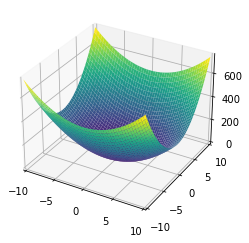

In [16]:
# Autovalores da Hessiana
L = 10;
m=5;

# Definição da função quadrática bidimensional
def z_function(x,y):
    return (m*x **2 + L*y **2)/2

x = np.arange(-10, 10, 0.05)
y = np.arange(-10, 10, 0.05)

X,Y = np.meshgrid(x,y)

Z = z_function(X,Y)

ax = plt.subplot(projection="3d")
ax.plot_surface(X, Y, Z, cmap = "viridis")
ax.set_xlim(-10, 10)
ax.set_ylim(-10, 10)
plt.show()

### Convexa (<u>e</u> não Fortemente Convexa)

A convexidade forte é um caso particular de convexidade. Isto é, toda função fortemente convexa é, também, convexa. O caso admitido pelas funções convexas que não ocorre para funções fortemente convexas é aquele em que o menor autovalor é igual a 0. Isto é quando $m=0$. Entendemos então, que além deste caso patológico, esta definição contém a situação descrita no caso anterior, onde $m>0$. Em suma, quando a função $f$ é <b>convexa</b>, $m\geq 0$. Como podemos ver, esta situação admite a existência de mínimos degenerados: existe mínimo, mas ele não é único.

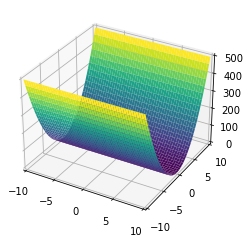

In [17]:
# Autovalores da Hessiana
L = 10;
m=0;

# Definição da função quadrática bidimensional
def z_function(x,y):
    return (m*x **2 + L*y **2)/2

x = np.arange(-10, 10, 0.05)
y = np.arange(-10, 10, 0.05)

X,Y = np.meshgrid(x,y)

Z = z_function(X,Y)

ax = plt.subplot(projection="3d")
ax.plot_surface(X, Y, Z, cmap = "viridis")
ax.set_xlim(-10, 10)
ax.set_ylim(-10, 10)
plt.show()

### Não-Convexa

Quando a função $f$ é <b>não-convexa</b>, $m<0$. Neste caso, a função $f$ admite pontos de sela.

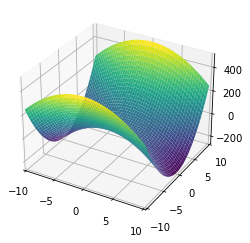

In [18]:
# Autovalores da Hessiana
L = 10;
m=-5;

# Definição da função quadrática bidimensional
def z_function(x,y):
    return (m*x **2 + L*y **2)/2

x = np.arange(-10, 10, 0.05)
y = np.arange(-10, 10, 0.05)

X,Y = np.meshgrid(x,y)

Z = z_function(X,Y)

ax = plt.subplot(projection="3d")
ax.plot_surface(X, Y, Z, cmap = "viridis")
ax.set_xlim(-10, 10)
ax.set_ylim(-10, 10)
plt.show()

A seguir, iremos implementar os algoritmos de descida de gradiente e testar a convergência ao mínimo para uma função quadrática $N$-dimensional. Além disso, restringiremos nossa análise para quadráticas <b>fortemente convexas</b>.

## 2.1. Implementação do Gradiente Descendente (GD)

Uma das técnicas que se é utilizada para obter o mínimo de uma função é o gradiente descendente. Esta técnica consiste na computação iterativa do mínimo de uma função objetivo através de passos nas direções de máxima variação: ou seja, passsos na direção paralela ao gradiente. 

\begin{align*}
 \boldsymbol{x}^{k+1}=\boldsymbol{x}^{k}-\alpha_k\nabla f(\boldsymbol{x}^{k})
\end{align*}

Onde $k$ é a iteração atual, e $\alpha_k$ é o <b>learning rate</b> ou a <b>taxa de aprendizado</b> do algoritmo GD. Para funções $L$-suaves:

\begin{align*}
 \left\|\nabla f (\boldsymbol{x})-\nabla f (\boldsymbol{y})\right\| \leq L \left\|\boldsymbol{x}-\boldsymbol{y}\right\|
\end{align*}

A taxa de aprendizado é a melhor possível quando $\alpha_k = 1/L$. No caso da função quadrática, $L$ corresponderá justamente ao maior autovalor da Hessiana.

### Definições preliminares

Para a fase de aplocação do $\text{GD}$ e $\text{SGD}$, utilizamos uma quadrática $n$-dimensional.

In [23]:
# Dimensão da qudrática
d = 3;

# Cria listas de pontos iniciais aleatórios, e autovalores aleatórios
start_list = list();
eig_list = list();

for i in range(10 ** d):
    rand_float1 = random.uniform(0.1, 1)
    rand_float2 = random.uniform(-2, 2)
    eig_list.append(rand_float1)
    start_list.append(rand_float2)

In [24]:
# Defino função quadrática N-dimensional diagonalizada
def obj_quad_n(x):
    i = 0;
    sum = 0;
    while i < len(x):
        sum+=eig_list[i]*x[i]**2
        i+=1
    return sum/2

# Defino o gradiente da quadrática
def grad_quad_n(x):
    vec = x;
    i = 0;
    while i < len(x):
        vec[i]=eig_list[i]*x[i]
        i+=1
    return vec

### Gradiente Descendente (GD)

Definidas as funções objetivo e gradiente, vamos implementar o GD. Em seguida, vamos plotar os seguintes gráficos:

1. Valor da objetiva vs. iterações.
2. Iterações vs. taxa de aprendizado.
3. Iterações vs. dimensão da quadrática.

In [25]:
# Algoritmo de descida do gradiente. Além dos argumentos referentes à função objetiva, gradiente, taxa de aprendizado, toma como argumento a
# posição inicial para o cálculo e a tolerância, a qual quantificaremos como potência de 0.1.
def grad_desc(obj, grad, learning_rate, start_pos, tol):
    
    # Armazena os valores iniciais
    current_pos = list(start_pos);  
    current_obj = obj(start_pos);
    current_grad = grad(start_pos);
    n_iterations = 0;

    # Vetor que irá armazenar os valores da função objetiva por iteração 
    desc_positions = list();
    
    # Vetor que irá armazenar os valores da função objetiva por iteração 
    obj_values = list();
    obj_values.append(current_obj);
    new_pos = current_pos;

    while np.linalg.norm(current_grad) > 0.1** tol:
              
        # Atualiza as posições utilizando o gradiente total
        i=0;
        while i < len(current_grad):
            new_pos[i]= current_pos[i] - learning_rate * current_grad[i]
            i+=1;

        # Re-calcula a objetiva e o gradiente total
        current_obj = obj(new_pos);
        current_grad = grad(new_pos);
        current_pos = new_pos
        
        #desc_positions.append(new_pos);
        #print(desc_positions)
        
        # Adiciona 1 no contador de iterações e armazena a nova tupla (objetiva,iteração)
        n_iterations+=1;
        obj_values.append(current_obj);

    return n_iterations, obj_values, current_pos

#### Valor da Objetiva vs. Iterações

0.0043101999999635154


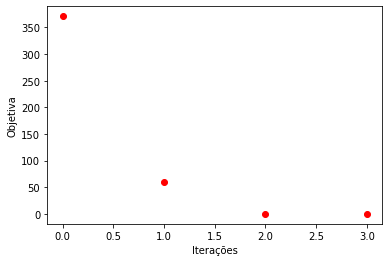

In [26]:
start = time.perf_counter()
grad1 = grad_desc(obj_quad_n, grad_quad_n, 1/max(eig_list), start_list, 5);
end = time.perf_counter()
print(end-start)

x_val = [x for x in range(len(grad1[1]))];
y_val = grad1[1];

#plt.plot(x_val,y_val)
plt.plot(x_val,y_val,'or')
plt.xlabel('Iterações')
plt.ylabel('Objetiva')
plt.show()

#### Iterações vs. taxa de aprendizado

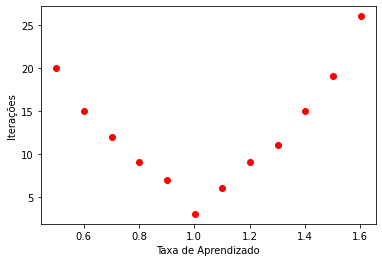

In [27]:
start_list = list();
eig_list = list();
for _ in range(10 ** 3):
        rand_float1 = random.uniform(0.1, 1)
        rand_float2 = random.uniform(-2, 2)
        eig_list.append(rand_float1)
        start_list.append(rand_float2)

# Iterações sobre taxa de aprendizado
i = 0;
learn_list = list();
iter_list = list()
while i < 12:  
    learn_rate = 1/max(eig_list)+0.1*(i-5);
    grad1 = grad_desc(obj_quad_n, grad_quad_n, learn_rate, start_list, 5);
    learn_list.append(learn_rate)
    iter_list.append(grad1[0])
    i+=1

x_val = [item for item in learn_list];
y_val = [item for item in iter_list];

plt.plot(x_val,y_val,'or')

plt.xlabel('Taxa de Aprendizado')
plt.ylabel('Iterações')
plt.show()

Vemos que a taxa de aprendizado é mínima precisamente quando $L=1$, ou seja, o maior autovalor da quadrática.

#### Iterações vs. dimensão da quadrática

602.1595815999999


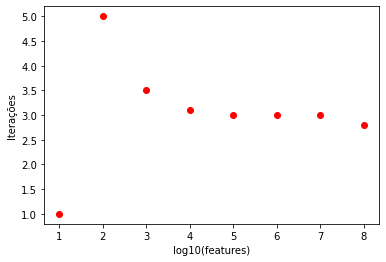

In [28]:
start = time.perf_counter();

# Média sobre 10 inicializações, para calcular a média
i = 0;
R = 8;
iter_list = list();
time_list = list();
while i < R:
    ping = time.perf_counter();
    j = 0;
    n_iter = 0;
    while j < 10:
        start_list = list();
        eig_list = list();
        for _ in range(10 ** i):
            rand_float1 = random.uniform(0.1, 1)
            rand_float2 = random.uniform(-2, 2)
            eig_list.append(rand_float1)
            start_list.append(rand_float2)
        grad1 = grad_desc(obj_quad_n, grad_quad_n, 1/max(eig_list), start_list, 5);
        n_iter+=grad1[0];
        j+=1;
    pong = time.perf_counter();
    iter_list.append(n_iter/10);
    time_list.append((pong-ping)/10);
    i+=1
end = time.perf_counter();
print(end-start)

x_val = list(range(1, R+1));
y_val = [item for item in iter_list];

plt.plot(x_val,y_val,'or')

plt.xlabel('log10(features)')
plt.ylabel('Iterações')
plt.show()

#### Tempo total vs. dimensão

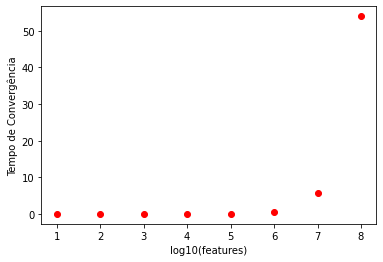

In [33]:
x_val = list(range(1, R+1));
y_val = [item for item in time_list];

plt.plot(x_val,y_val,'or')

plt.xlabel('log10(features)')
plt.ylabel('Tempo de Convergência')
plt.show()

Onde vemos, claramente, que apesar do número de iterações diminuir com a ordem da quadrática, o tempo de convergência de fato aumenta conforme esperado. 

## 2.2. Implementação do Gradiente Descendente Estocástico (SGD)

Quando a computação do gradiente total é computacionalmente custoso e/ou os dados coletados são ruidosos, costuma-se utilizar o método do Gradiente Descendente Estocástico. A ideia deste algoritmo é fazer um cálculo do gradiente 'parcial', isto é, calculando a derivada parcial da função objetiva em uma ou várias direções (um <b>batch</b>) e realizando a iteração na direção deste gradiente parcial. Isto é:

\begin{align*}
   \boldsymbol{x}^{k+1}=\boldsymbol{x}^{k}-\alpha_k\nabla f_{k}(\boldsymbol{x}^{k})
\end{align*}

\begin{align*}
    \nabla f_{k}(\boldsymbol{x}^{k})=&\dfrac{1}{n}\sum_{s=1}^n \left.\dfrac{\partial f(\boldsymbol{x})}{\partial x_{i_s}}\right|_{\boldsymbol{x}=\boldsymbol{x}^k} \boldsymbol{e}_{i_s}\\
    =&\dfrac{1}{n}\sum_{s=1}^n \left[\nabla f(\boldsymbol{x}^k)\right]_{i_s} \boldsymbol{e}_{i_s}
\end{align*}

Onde $i_s\in \left\{1,2,...,N\right\}$ é o índice escolhido aleatoriamente, determinando as direções para o cálculo médio do gradiente parcial e $\boldsymbol{e}_{i_s}$ é o vetor unitário na $i_s$-ésima direção. Desta forma, cada iteração será menos custosa.

Porém, o preço que pagamos por não calcular o gradiente total é que o algoritmo irá demorar mais tempo para convergir, visto que a direção de deslocamento entre iterações não será na direção de maior variação da função. Uma consequência notável disso é que se a razão entre o maior e menor autovalores da Hessiana de $f$ for grande, o algoritmo corre o risco de oscilar bastnate em torno do mínimo. Para evitar este problema, é usual utilizar uma taxa de aprendizado decrescente com as iterações.

Convencionamos o tamanho do 'batch' de direções como $64$.

In [34]:
# Defino o gradiente parcial em um direção
def partial_grad_quad_n(x, index):
    return eig_list[index]*x[index]

In [35]:
start_list = list();
eig_list = list();

for i in range(10 ** 3):
    rand_float1 = random.uniform(0.1, 1)
    rand_float2 = random.uniform(-2, 2)
    eig_list.append(rand_float1)
    start_list.append(rand_float2)

In [36]:
# Algoritmo de descida do gradiente estocástico
def stoch_grad_desc(obj, partial_grad, learning_rate, start_pos, tol, batch_size):
    
    # Armazena os valores iniciais
    current_pos = list(start_pos);  
    current_obj = obj(start_pos);
    current_grad = [0] * len(start_pos); # Valor inicial do gradiente
    n_iterations = 0;

    # Vetor que irá armazenar os valores da função objetiva por iteração 
    desc_positions = list();
    
    # Vetor que irá armazenar os valores da função objetiva por iteração 
    obj_values = list();
    obj_values.append(current_obj);
    new_pos = current_pos;

    while np.linalg.norm(current_grad) > 0.1** tol or n_iterations == 0:
              
        # Atualiza as posições utilizando o gradiente parcial
        i = 0;
        batch_list = np.random.choice(len(start_pos), size=batch_size, replace=False)
        while i < batch_size:
            n = batch_list[i];
            current_grad[n] = partial_grad(current_pos, n)
            new_pos[n]= current_pos[n] - learning_rate * current_grad[n]
            i+=1;

        # Re-calcula a objetiva e o gradiente total
        current_obj = obj(new_pos);
        current_pos = new_pos
        
        #desc_positions.append(new_pos);
        #print(desc_positions)
        
        # Adiciona 1 no contador de iterações e armazena a nova tupla (objetiva,iteração)
        n_iterations+=1;
        obj_values.append(current_obj);

    return n_iterations, obj_values, current_pos

#### Objetiva vs. iterações


0.6490086999997402


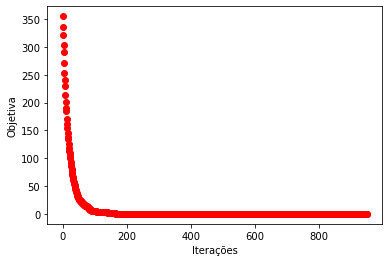

In [37]:
start = time.perf_counter()
grad2 = stoch_grad_desc(obj_quad_n, partial_grad_quad_n, 1/max(eig_list), start_list, 3, 64);
end = time.perf_counter()
print(end-start)

x_val = [x for x in range(len(grad2[1]))];
y_val = grad2[1];

#plt.plot(x_val,y_val)
plt.plot(x_val,y_val,'or')
plt.xlabel('Iterações')
plt.ylabel('Objetiva')
plt.show()

Onde verificamos que, de fato, este algoritmo leva mais iterações para convergir.

#### Iterações vs. fator de amplificação

Para acelerar a convergência do $\text{SGD}$, é usual utilizar um fator $\gamma$ de amplificação sobre a taxa de aprendizado. A escolha deste parâmetro varia com o problema. Para descobrir qual funciona melhor para nós, testamos a convergência para várias iterações da quadrática de dimensão $3$.

44.78956870000002


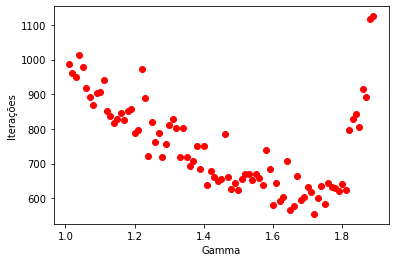

In [38]:
iter_list = list();
gamma_list = list();
R = 3;

start_list = list();
eig_list = list();
for _ in range(10 ** R):
    rand_float1 = random.uniform(0.1, 1)
    rand_float2 = random.uniform(-2, 2)
    eig_list.append(rand_float1)
    start_list.append(rand_float2)
        
i = 1;
ping = time.perf_counter();
while i < 9*10 ** 1:
    grad2 = stoch_grad_desc(obj_quad_n, partial_grad_quad_n, (1.0+0.01*i)/max(eig_list), start_list, 3, 64);
    gamma_list.append((1.0+0.01*i))
    iter_list.append(grad2[0])
    i+=1
pong = time.perf_counter();
print(pong-ping)

x_val = [item for item in gamma_list];
y_val = [item for item in iter_list];

#plt.plot(x_val,y_val)
plt.plot(x_val,y_val,'or')

plt.xlabel('Gamma')
plt.ylabel('Iterações')
plt.show()

In [39]:
print('Menor tempo: ',min(iter_list),'Gamma: ', gamma_list[iter_list.index(min(iter_list))])

Menor tempo:  555 Gamma:  1.72


# 3. Implementação do Classificador Logístico/Binário

Antes de implementarmos a regressão logística multinomial, vamos estudar a sua versão mais simples, onde temos apenas duas classificações: $1 $(<b>positiva</b>) e $0$ (<b>negativa</b>). Relacionado à base de dados em questão, o algoritmo que estamos propondo aqui identificará se o dado inserido corresponde a algum dígito da nossa escolha, ou não. Por exemplo, se escolhemos o dígito $3$, este algoritmo não conseguirá identificar se o dígito é $2$ ou $7$: ele apenas fará uma previsão se o dígito é $3$ ou não.

Para motivar a forma que o algoritmo irá tomar, vamos resumir o problema proposto pela Tarefa. Queremos um algoritmo que tome como input imagens de dígitos desenhados à mão - de classificação desconhecida - e que produza como output a probabilidade de que essa imagem corresponde a um determinado dígito. Definindo a classificação como sendo $y\in \{0,1\}$ e o dado de input como sendo $\boldsymbol{x}$, o que queremos calcular, em efeito, é a seguinte distribuição de probabilidade:

\begin{align*}
    p\left(y|\boldsymbol{x}\right)=  \begin{cases}
       f\left(\boldsymbol{x}\right),& \text{se } y =1\\
       1- f\left(\boldsymbol{x}\right), &\text{se }y=0
    \end{cases}
\end{align*}
Onde entendemos $p(a| b)$ é a probabilidade condicional de obtermos o resultado $a$ dado que $b$ ocorreu. Agora, a pergunta que não quer calar é: <i>Qual a forma funcional de $f$</i>? Evidentemenete, existem inúmeras formas que podemos modelar essa probabilidade utilizando o dataset de input. Inclusive, poderíamos estar tentados a impor uma relação afim entre $f$ e os dados, como, por exemplo:

\begin{align*}
    f(\boldsymbol{x};\boldsymbol{w},b)=\boldsymbol{w}^T\boldsymbol{x}+b
\end{align*}
Onde, além do input $\boldsymbol{x}$, a nossa função $f$ passa a ser uma função de dois inputs adicionais, a lista de parâmetros $\boldsymbol{w}$ (chamadas de <i>pesos</i>) e do parâmetro $b$ (chamado de <b>bias</b> ou <b>viés</b>). A ideia seria, portanto, encontrar os parâmetros ($\boldsymbol{w},b$) que mais aproximam a probabilidade $p$ da distribuição proposta pelos dados.

Porém, apesar da simplicidade do modelo linear proposto, a relação descrita anteriormente entre esta função $f$ e a probabilidade  $p$ dita que, para todos os inputs, esta função deverá satisfazer $0\leq  f(\boldsymbol{x};\boldsymbol{w},b)\leq 1$. Dependendo da forma dos inputs, a aplicação desta restrição sobre os estágios intermediários da otimização dos parâmetros pode ser algo extremamente inconveniente. Por este motivo, na regressão logística, é comum utilizar a <b>função sigmoide</b>:

\begin{align*}
    f(\boldsymbol{x};\boldsymbol{w},b)=\sigma (\boldsymbol{w}^T\boldsymbol{x}+b)=\dfrac{1}{1+e^{-(\boldsymbol{w}^T\boldsymbol{x}+b)}}
\end{align*}
Desta forma, quaisquer que sejam os valores dos parâmetros, a função $f$ estará restrita ao intervalo $[0,1]$, consistente com a de uma distribuição de probabilidade. Esta será, então, a função utilizada para modelar a probabilidade $p$. 

Agora, determinada a função modelo $f$, como sabemos que parâmetros $\boldsymbol{w},b$ são melhores ou piores para modelar os dados? Como encontramos os parâmetros ótimos? Em problemas de otimização, este é precisamente o trabalho da função objetivo.

Até o momento, tratamos da distribuição de probabilidade $p$ associada a apenas um datapoint $\boldsymbol{x}$. Na prática, teremos $N$ datapoints, os quais representaremos como a lista $\{\boldsymbol{x}_1,\boldsymbol{x}_2,...,\boldsymbol{x}_N\}$. Considerando que cada um destes datapoints são referentes a eventos independentes um do outro, a probabilidade de obtermos uma lista de $N$ classificações $\{y_1,y_2,...,y_N\}$ será dada pelo seguinte produto de probabilidades, definido como a <b>verossimilhança</b> (ou '<b>likelihood</b>'):

\begin{align*}
    L(\boldsymbol{w},b)=&p(y_1|\boldsymbol{x}_1;\boldsymbol{w},b)p(y_1|\boldsymbol{x}_2;\boldsymbol{w},b)...p(y_N|\boldsymbol{x}_N;\boldsymbol{w},b)\\
    =&\prod_{i=1}^N p(y_i|\boldsymbol{x}_i;\boldsymbol{w},b)
\end{align*}
Entendemos que o melhor fit da distribuição de probabilidade a partir dos parâmetros será aquela que maximiza a verossimilhança acima. No entanto, esta nem é a forma mais prática de representarmos a função objetivo. Ao invés de tratar um produto de funções sigmoide, é muito mais tractável maximizarmos o logaritmo da verossimilhança (ou minimizarmos o logaritmo negativo). Além disso, como cada probabilidade $p$ possui dois resultados, podemos representar os dois resultados utilizando uma única expressão, dada abaixo:

\begin{align*}
   p(y_i|\boldsymbol{x}_i;\boldsymbol{w},b)=  \begin{cases}
      \sigma \left(\boldsymbol{w}^T\boldsymbol{x}_i+b\right),& \text{se } y_i =1\\
       1- \sigma\left(\boldsymbol{w}^T\boldsymbol{x}_i+b\right), &\text{se }y_i=0
    \end{cases}\\
    =      \sigma \left(\boldsymbol{w}^T\boldsymbol{x}_i+b\right)^{y_i}\left[1-     \sigma \left(\boldsymbol{w}^T\boldsymbol{x}_i+b\right)\right]^{(1-y_i)}
\end{align*}

Tomando o logaritmo natural negativo da verossimilhança e substituindo a representação acima, temos:

\begin{align*}
  \ell (\boldsymbol{w},b) =&- \log L(\boldsymbol{w},b)\\
  =&-\sum_{i=1}^N \log p(y_i|\boldsymbol{x}_i;\boldsymbol{w},b)\\
   =&-\sum_{i=1}^N \left[y_i \log \left(\sigma(\boldsymbol{w}^T\boldsymbol{x}_i+b)\right)+(1-y_i)\log \left(1-\sigma(\boldsymbol{w}^T\boldsymbol{x}_i+b)\right)\right]
\end{align*}
A qual será a nossa função objetivo.

## 3.1. Definição do Gradiente e Hessiana

Outra vantagem de se utilizar a função sigmoide é que possui gradiente e Hessiana bem definidos. Assim, podemos usar o resultado já pronto do gradiente para colocar nas rotinas de aprendizagem. Decidi não seguir com a recomendação de utilizar as bibliotecas do PyTorch e/ou TensorFlow.

### Gradiente

Devido à forma linear no interior do argumento da função sigmoide, as derivadas parciais dos pesos são proporcionais à derivada parcial com respeito ao bias $b$.

\begin{align*}
    \dfrac{\partial}{\partial w_j}  \sigma(\boldsymbol{x}_i;\boldsymbol{w},b) = (\boldsymbol{x}_{i})_j \dfrac{\partial}{\partial b}   \sigma(\boldsymbol{x}_i;\boldsymbol{w},b)
\end{align*}

Onde por $(\boldsymbol{x}_{i})_j$ entendemos a '$j$-ésima feature do $i$-ésimo datapoint. Calculando a derivada parcial com respeito ao bias, temos:

\begin{align*}
    \dfrac{\partial}{\partial b}  l(\boldsymbol{w},b)=&-\sum_{k=1}^N \left[y_k \log \left(\sigma \left(\boldsymbol{x}_k;\boldsymbol{w},b\right)\right)+(1-y_k)\log \left(1-\sigma \left(\boldsymbol{x}_k;\boldsymbol{w},b\right)\right)\right]\\
    =&-\sum_{k=1}^N \left[\dfrac{y_k}{\sigma \left(\boldsymbol{x}_k;\boldsymbol{w},b\right)}- \dfrac{1-y_k}{1-\sigma \left(\boldsymbol{x}_k;\boldsymbol{w},b\right)}\right] \dfrac{\partial}{\partial b}\sigma \left(\boldsymbol{x}_k;\boldsymbol{w},b\right)\\
    =&-\sum_{k=1}^N \left[\dfrac{y_k(1-\sigma \left(\boldsymbol{x}_k;\boldsymbol{w},b\right))-(1-y_k)\sigma \left(\boldsymbol{x}_k;\boldsymbol{w},b\right)}{\sigma \left(\boldsymbol{x}_k;\boldsymbol{w},b\right)(1-\sigma \left(\boldsymbol{x}_k;\boldsymbol{w},b\right))}\right] \dfrac{\partial}{\partial b}\sigma \left(\boldsymbol{x}_k;\boldsymbol{w},b\right)\\
    =&-\sum_{k=1}^N \left[\dfrac{y_k-\sigma \left(\boldsymbol{x}_k;\boldsymbol{w},b\right)}{\sigma \left(\boldsymbol{x}_k;\boldsymbol{w},b\right)(1-\sigma \left(\boldsymbol{x}_k;\boldsymbol{w},b\right))}\right] \dfrac{\partial}{\partial b}\sigma \left(\boldsymbol{x}_k;\boldsymbol{w},b\right)
\end{align*}

Para simplificar as contas, definimos $Z=\boldsymbol{w}^T\boldsymbol{x}_i+b$, tal que $\dfrac{\partial Z}{\partial b}=1$.

\begin{align*}
    \sigma (\boldsymbol{x}_k;\boldsymbol{w},b)&=\dfrac{1}{1+e^{-Z}}\\
    \dfrac{\partial}{\partial b}   \sigma (\boldsymbol{x}_k;\boldsymbol{w},b)&=-\left(\dfrac{1}{1+e^{-Z}}\right)^2\left(-e^{-Z}\right)(1)\\
    &= \sigma (\boldsymbol{x}_k;\boldsymbol{w},b)^2\left(\dfrac{1}{ \sigma (\boldsymbol{x}_k;\boldsymbol{w},b)}-1\right)\\
    &= \sigma (\boldsymbol{x}_k;\boldsymbol{w},b)\left(1- \sigma (\boldsymbol{x}_k;\boldsymbol{w},b)\right)
\end{align*}

Substituindo o resultado na expressão original e usando o resultado para obter as derivadas parciais dos pesos, temos:

\begin{align*}
   \dfrac{\partial}{\partial b}  l(\boldsymbol{w},b)=&\sum_{k=1}^N\left[\sigma \left(\boldsymbol{x}_k;\boldsymbol{w},b\right)- y_k\right]
\end{align*}


\begin{align*}
   \dfrac{\partial}{\partial w_j}  l(\boldsymbol{w},b)=&\sum_{k=1}^N(\boldsymbol{x}_k)_j\left[\sigma \left(\boldsymbol{x}_k;\boldsymbol{w},b\right)- y_k\right]
\end{align*}


Além disso, podemos majorar e inferiorizar os gradientes utilizando os dados do problema.

\begin{align*}
   -N = N\left[\min\left(\sigma \left(\boldsymbol{x}_k;\boldsymbol{w},b\right)\right)-\max(y_k)\right]\leq \sum_{k=1}^N\left[\sigma \left(\boldsymbol{x}_k;\boldsymbol{w},b\right)- y_k\right] \leq N\left[\max\left(\sigma \left(\boldsymbol{x}_k;\boldsymbol{w},b\right)\right)-\min(y_k)\right] = N
\end{align*}


\begin{align*}
   -N = N\max((\boldsymbol{x}_k)_j)\left[\min\left(\sigma \left(\boldsymbol{x}_k;\boldsymbol{w},b\right)\right)-\max(y_k)\right]\leq \sum_{k=1}^N(\boldsymbol{x}_k)_j\left[\sigma \left(\boldsymbol{x}_k;\boldsymbol{w},b\right)- y_k\right] \leq N\max((\boldsymbol{x}_k)_j)\left[\max\left(\sigma \left(\boldsymbol{x}_k;\boldsymbol{w},b\right)\right)-\min(y_k)\right] = N
\end{align*}

Onde para estabelecer as desigualdades, utilizamos que $y_k \in \{0,1\}$, que a função sigmoide é limitada ($0\leq \sigma(\boldsymbol{w},b)\leq 1$) e que o valor máximo de cada feature é $1$ (pela normalização). Assim, o gradiente desta função objetiva é limitado.

### Hessiana

No cálculo do gradiente, vimos que:

\begin{align*}
   \dfrac{\partial}{\partial b}  l(\boldsymbol{w},b)=&\sum_{i=1}^N\left[\sigma \left(\boldsymbol{x}_i;\boldsymbol{w},b\right)- y_k\right]
\end{align*}


\begin{align*}
   \dfrac{\partial}{\partial w_j}  l(\boldsymbol{w},b)=&\sum_{i=1}^N(\boldsymbol{x}_i)_j\left[\sigma \left(\boldsymbol{x}_i;\boldsymbol{w},b\right)- y_i\right]
\end{align*}

Tomando a derivada segunda destas expressões, temos:

\begin{align*}
   \dfrac{\partial^2}{\partial b^2 }  l(\boldsymbol{w},b)=&\sum_{i=1}^N\dfrac{\partial}{\partial b}\sigma \left(\boldsymbol{x}_i;\boldsymbol{w},b\right)=\sum_{i=1}^N\sigma (\boldsymbol{x}_i;\boldsymbol{w},b)\left(1- \sigma (\boldsymbol{x}_i;\boldsymbol{w},b)\right)
\end{align*}

\begin{align*}
   \dfrac{\partial^2}{\partial w_j\partial b}  l(\boldsymbol{w},b)=&\sum_{i=1}^N\dfrac{\partial}{\partial w_j}\sigma \left(\boldsymbol{x}_i;\boldsymbol{w},b\right)=\sum_{i=1}^N(\boldsymbol{x}_i)_j\sigma (\boldsymbol{x}_i;\boldsymbol{w},b)\left(1- \sigma (\boldsymbol{x}_i;\boldsymbol{w},b)\right)
\end{align*}

\begin{align*}
   \dfrac{\partial}{\partial w_j\partial w_k}  l(\boldsymbol{w},b)=&\sum_{i=1}^N(\boldsymbol{x}_i)_j\dfrac{\partial}{\partial w_k}\sigma \left(\boldsymbol{x}_i;\boldsymbol{w},b\right)=\sum_{i=1}^N(\boldsymbol{x}_i)_j(\boldsymbol{x}_i)_k\sigma (\boldsymbol{x}_i;\boldsymbol{w},b)\left(1- \sigma (\boldsymbol{x}_i;\boldsymbol{w},b)\right)
\end{align*}

Se, por simplicidade, denominarmos o viés como um peso adicional relacionado a uma feature que só tem valor '$1$', então podemos reescrever todas as derivadas acima da seguinte forma:


\begin{align*}
   H_{jk}(\boldsymbol{w},b) \coloneqq \dfrac{\partial}{\partial w_j\partial w_k}  l(\boldsymbol{w},b)=\sum_{i=1}^N(\boldsymbol{x}_i\boldsymbol{x}_i^T)_{jk}\sigma (\boldsymbol{x}_i;\boldsymbol{w},b)\left(1- \sigma (\boldsymbol{x}_i;\boldsymbol{w},b)\right)
\end{align*}

\begin{align*}
   \Rightarrow \boldsymbol{H}(\boldsymbol{w},b) \coloneqq \dfrac{\partial}{\partial w_j\partial w_k}  l(\boldsymbol{w},b)=\sum_{i=1}^N(\boldsymbol{x}_i\boldsymbol{x}_i^T)\sigma (\boldsymbol{x}_i;\boldsymbol{w},b)\left(1- \sigma (\boldsymbol{x}_i;\boldsymbol{w},b)\right)
\end{align*}


Consequentemente:



\begin{equation*}
0 \leq \left\|\boldsymbol{H}\right\|\leq \dfrac{N}{4}\left\|\lambda_{max}\left(\boldsymbol{x}_i\boldsymbol{x}_i^T\right)\right\|
\end{equation*}

Onde a operação $\lambda_{\text{max}}(A)$ indica o maior autovalor de $A$. Novamente, como  $0\leq \sigma(\boldsymbol{w},b)\leq 1$, e o valor da Hessiana é máximo para $\sigma(\boldsymbol{w},b)=\dfrac{1}{2}$, concluímos que a Hessiana será positiva semi-definida, e portanto que trata-se de uma função objetiva <b>convexa</b>. Além disso, também será $L$-suave, visto que o maior valor possível da Hessiana é limitado. 


## 3.2. Implementação da Regressão Logística

### Com Gradiente Descendente

In [39]:
class logistic_regression:
    
    def __init__(self, learn_rate = 0.1 ** 5, n_iter = 10 ** 2, tol = 4):
        self.learn_rate = learn_rate;
        self.n_iter = n_iter;
        self.tol = tol;
        self.weights = None;
        self.bias = None;
    
    def sigmoid(self, x):
        y = np.dot(self.weights, x)+ self.bias;
        return 1 / (1 + np.exp(-y))
    
    def trainGD(self, X, y):

        # Definições iniciais para treino
        num_samples = len(X);
        num_features = len(X[0]);
        self.weights = [0 for x in range(num_features)];
        self.bias = 0;
        #reg_factor = 10 ** 2;

        # Valores iniciais dos gradientes
        grad_w = self.weights;
        grad_b = self.bias;

        # Descida do gradiente
        i = 0;
        while i < self.n_iter:
            start1 = time.perf_counter()
            # Monta o vetor com as sigmoides de cada datapoint de X
            sig_X = [self.sigmoid(x) for x in X];
            diff = [a-b for (a,b) in zip(sig_X,y)];

            # Cálculo dos gradientes. Note que estamos usando o fato que os gradientes dos pesos serão proporcionais ao gradientes do bias, conforme
            # as equações no cabeçalho da seção
            grad_b = sum(diff);
            grad_w_buff = [[scalar * u for u in x] for (scalar,x) in zip(diff,X)]
            grad_w = [sum(x) for x in zip(*grad_w_buff)]

            #Atualização dos pesos e do bias
            self.weights = [(a-b*self.learn_rate) for (a,b) in zip(self.weights,grad_w)];
            self.bias-=self.learn_rate*grad_b;
            end1 = time.perf_counter()
            print(end1-start1)
            abs_grad = [abs(x) for x in grad_w];
            print(i, grad_b/num_samples, sum(abs_grad)/784/num_samples)
            i+=1;

    def predictGD(self, test):
        sig = [self.sigmoid(x) for x in test];
        predictions = [1 if y >= 0.5 else 0 for y in sig]; 
        return predictions

In [40]:
# Simplificação da nomenclatura
model = logistic_regression()

# Treino do modelo
start = time.perf_counter()
model.trainGD(bin_X,bin_y)
end = time.perf_counter()

2.3900886999999784
0 0.0 0.01483378166081252
2.447802500000762
1 0.028215379990385318 0.012531497810196073
2.401962599999024
2 0.038627961826194206 0.011439009919069397
2.4695725000001403
3 0.04203583682631111 0.01070612458134507
2.4265751000002638
4 0.04269977789824096 0.010100023481912445
2.4984668000015517
5 0.04230533232487758 0.009561940720564013
2.532078599999295
6 0.04152299708093157 0.009071292183646761
2.614810999999463
7 0.04061877241228471 0.008624365812824147
2.4530278000002
8 0.03969665348105749 0.008212028381657964
2.4838620999998966
9 0.03879574840764686 0.007830703925081164
2.4277657000002364
10 0.03792932791804244 0.007479354913141105
2.4481221999994887
11 0.037100547599846205 0.007154733777487422
2.3376139999982115
12 0.03630876484818213 0.0068535256390073835
3.1506800999995903
13 0.035552054229104894 0.006575742444079892
2.36934520000068
14 0.03482818577205335 0.006316875579530208
2.4795659000010346
15 0.03413498464052014 0.006075869018621209
2.3351753000006283
16 0.

In [41]:
# Lista de predições
predictions = model.predictGD(bin_Xtest);

# Comparação com classificações reais
comparison = list();
for i in range(len(bin_ytest)):
    if bin_ytest[i] == predictions[i]:
        comparison.append(1);
    if bin_ytest[i] != predictions[i]:
        comparison.append(0)

# Cálculo da acurácia
accuracy = np.sum(comparison)/len(bin_ytest)

print(f"Accuracy: {accuracy}")

Accuracy: 0.8938888888888888


# 4. Implementação do Classificador Multinomial

Como havíamos mencionado, isto se trata de uma versão mais elaborada da regressão logística binária. Ou seja, agora temos $K$ classificações.

\begin{align*}
   p(y_i|\boldsymbol{x}_i;\boldsymbol{W},\boldsymbol{b})=  \begin{cases}
      \sigma \left(\boldsymbol{w}_1^T\boldsymbol{x}_i+b_1\right),& \text{se } y_i =1\\
       \sigma\left(\boldsymbol{w}_2^T\boldsymbol{x}_i+b_2\right), &\text{se }y_i=2\\
     &  \vdots\\
        \sigma\left(\boldsymbol{w}_K^T\boldsymbol{x}_i+b_K\right), &\text{se }y_i=K
    \end{cases}
\end{align*}
\begin{align*}
     \sigma \left(\boldsymbol{w}_j^T\boldsymbol{x}_i+b_j\right)=\dfrac{e^{\boldsymbol{w}_j^T\boldsymbol{x}_i+b_j}}{\sum_{j=1}^{K}e^{\boldsymbol{w}_j^T\boldsymbol{x}_i+b_j}}
\end{align*}

Onde $\boldsymbol{w}_j$ e  $b$ são o conjunto de pesos e viés a serem treinados para otimizar a $j$-ésima classificação, respectivamente. Para representar a probabilidade duma forma semelhante à regressão binária, definimos a função indicadora $\Delta (x)=\begin{cases}
    1, \;  x = 0\\
    0,  \;  x \neq 0
\end{cases}$, tal que:

\begin{align*}
       p(y_i|\boldsymbol{x}_i;\boldsymbol{W},\boldsymbol{b})=\prod_{k=1}^K \sigma \left(\boldsymbol{w}_k^T\boldsymbol{x}_i+b_k\right)^{\Delta (y_i-k)}
\end{align*}

E, portanto:

\begin{align*}
    l(\boldsymbol{W},\boldsymbol{b})=&-\sum_{i=1}^N\sum_{k=1}^K \Delta (y_i-k)\log \left(\sigma \left(\boldsymbol{w}_k^T\boldsymbol{x}_i+b_k\right)\right)\\
    =&\sum_{i=1}^N\sum_{k=1}^K \Delta (y_i-k)l(\boldsymbol{w}_k,b_k)
\end{align*}

A consequência da relação acima é que a função objetiva total será minimizada precisamente quando minimizarmos cada uma das funções objetivas respectivas a cada classificação, que por sua vez se reduzirão exatamente ao caso estudado na regressão logística binária. Ou seja, a função objetivo $l(\boldsymbol{W},\boldsymbol{b})$ é convexa e $L$-suave.

## 4.1. Redefinição dos Dados

O algoritmo tem dado problema devido ao enorme tamanho dos dados, tendo chegado a travar o computador e fechar o browser. Por conta disso, vou criar uma base de dados com $1200$ dados de cada dígito, separando $800$ de cada dígito para treino e $400$ para teste. 

In [174]:
# Reconstrução dos dados de treino
# Matriz identidade de tamanho variável. Suas colunas tem precisamente o formato necessário para os targets da regressão multinomial
def indicator(size):
    return [[1 if i == j else 0 for j in range(size)] for i in range(size)]
Y_bool = indicator(10);

# Tamanho dos dados
nom_size = 1200;
nom_train_size = 800;
nom_test_size = 400;

# Criação de tuplas (dígito, target) para todos os dados, e embaralho cada lista de dígitos.
nom_tuples = [[(x,v) for x in u] for (u,v) in zip(data_digits_h ,Y_bool)];
nom_tuples = [shuffle(a) for a in nom_tuples]

# Criação de dados de treino e teste para cada dígito
start = time.perf_counter();
nested_X_tuples = [x[:nom_train_size] for x in nom_tuples];
nom_X_tuples = [inner for outer in nested_X_tuples for inner in outer];
nom_X_tuples = shuffle(nom_X_tuples);
nom_X = [x[0] for x in nom_X_tuples];
nom_y = [x[1] for x in nom_X_tuples];

nested_Xtest_tuples = [x[-nom_test_size:] for x in nom_tuples];
nom_Xtest_tuples = [inner for outer in nested_Xtest_tuples for inner in outer];
nom_Xtest_tuples = shuffle(nom_Xtest_tuples);
nom_Xtest = [x[0] for x in nom_Xtest_tuples];
nom_ytest = [x[1] for x in nom_Xtest_tuples];
end = time.perf_counter();

print(len(nom_X),len(nom_y))
print(len(nom_Xtest),len(nom_ytest))
print(end-start)

8000 8000
4000 4000
0.030800500000623288


## 4.2. Implementação da Regressão Logística Multinomial, com GD e SGD

A rotina encontrada abaixo é o resultado final de bastantes tentativas heurísticas. O que quero dizer com isso é que a rotina abaixo difere do que esperaríamos de um $\text{GD}$ e $\text{SGD}$ convencional por conta de duas adições:

1. <b>Amplificação da taxa de aprendizado em direções 'ruins' </b>: A partir da implementação convencional, notamos que a variação da função objetivo estagnava rapidamente, e a acurácia de dígitos específicos ficava muito ruim. Isto é, o algoritmo acertava com $\geq 85\%$ probabilidade a classificação de praticamente todos os dígitos, mas para algum dígito (e.g., $8$) era $\sim 20\%$. Por este motivo, incluímos uma sub-rotina que procura o pior classificador de dígito (pior estimativa pela função $\text{softmax}$) e amplifica o passo do gradiente para os pesos referentes a este classificador. Isso melhorou muito a convergência. Provavelmente ajudou a rotina a 'escapar' de uma região de gradiente baixo que não correspondia a um mínimo da função objetivo.
2. <b>Atenuação condicional da taxa de aprendizado</b>: Outra observação que foi feita sobre a implementação convencional era que a taxa de convergência do algoritmo se demonstrava constante para determinados intervalos. Isto é, inicialmente a queda da função objetivo por iteração era aproximadamente constante. A partir de certo ponto (em torno da iteração $5$ para várias realizações), a função objetivo aumentava. Por conta da existência destes 'intervalos' de convergência constante, decidimos não atenuar completamente a taxa de aprendizado por iteração e somente se o passo seguinte aumentar a função objetivo. Assim, a rotina fica presa num loop onde atenua a taxa de aprendizado por um fator de $0.9$ até a função objetivo reduzir no próximo passo (claro, se isso não ocorrer para $100$ tentativas de redução do aprendizado, o loop é encerrado e a rotina como um todo encerra).

Em cada iteração, a rotina publica $3$ paradas, referentes a diferentes sub-rotinas. Inicialmente, incluí este passo para entender em que parte o algoritmos estava estagnando, mas acabei achando melhor deixar. Além disso, o algoritmo também publica a norma de Manhattan do gradiente do bias e dos pesos (divididos pelo número de amostras e pelo número de features) lado-a-lado e, por fim, o valor atual da função objetivo, a qual chamamos de 'perda' ou 'loss' conforme implementações usuais de regressão logística.

Por conta dos algoritmos levarem um certo tempo para serem concluídos, deixei a chamada do treino e das predições comentados.

In [377]:
# Do que consigo entender, uma 'classe' é um objeto que possui várias propriedades. Para algoritmos complexos de otimização,
# entendo que é muito conveniente utilizar este tipo de objeto
class mult_logistic_regression:

    # Valor inicial das propriedades, caso não sejam especificadas
    def __init__(self, learn_rate = 0.008, n_iter = 10, tol = 4):
        self.learn_rate = learn_rate;
        self.n_iter = n_iter;
        self.tol = tol;
        self.total_time = 0;
        self.loss_values = [];
        self.weight_list = [];
        self.bias_list = [];
        num_samples = 1200;
        num_features = 784;
        self.batch = None;
        
        # Os pesos agora serão divididos em 10 classes, uma para cada elemento do softmax. Além disso, serão gerados aleatoriamente 
        # com valores condtidos no intervalo abaixo
        lower_bound = -0.1**6
        upper_bound = 0.1**6
        
        # Inicializa os pesos e bias com valores aleatórios pequenos
        self.weights = [np.random.uniform(lower_bound, upper_bound, num_features) for _ in range(10)]
        self.bias = np.random.uniform(lower_bound, upper_bound, 10);
        self.weight_list.append(self.weights);
        self.bias_list.append(self.bias);
        
        
    def loss(self, X,y):

        # Computa, para cada datapoint, as probabilidades de ser cada dígito e armazena os valores
        probabilities = [self.softmax(x) for x in X]; 
    
        # Computa o logaritmo de cada resultado e multiplica pelo target
        loss_log = [[u*math.log(v+1e-12) for (u,v) in zip(a,b)] for (a,b) in zip(y, probabilities)]

        # Soma todas as entradas acima, resultando na função perda total
        loss_buff = [sum(y) for y in loss_log];
        loss = -sum(loss_buff);
        return loss;

    def softmax(self, x):
        #start = time.perf_counter()
        y = [np.dot(u,x)+v for (u,v) in zip(self.weights,self.bias)];
        z = [math.exp(w) for w in y];
        norm = sum(z);
        softmax = [q/norm for q in z];
        #end = time.perf_counter()
        #print(end-start)
        return softmax

    def softmaxSGD(self, x, batch_list):
        #start = time.perf_counter()
        
        # Seleciona os parâmetros a serem mudados
        W_buff = np.array(self.weights)
        W =W_buff[:,batch_list];

        # Rotina softmax usual
        y = [np.dot(u,x)+v for (u,v) in zip(W,self.bias)];
        z = [math.exp(w) for w in y];
        norm = sum(z);
        softmax = [q/norm for q in z];
        #end = time.perf_counter()
        #print(end-start)
        return softmax
        
    def trainGD(self, X, y):

        # Definições iniciais para treino
        num_samples = len(X);
        num_features = len(X[0]);
        w_buff = [0 for x in range(num_features)]
        self.loss_values.append(self.loss(X,y));
        
        # Gera gradientes com as mesmas dimensões da matriz de pesos e o vetor de bias
        grad_w = self.weights;
        grad_b = self.bias;

        # Descida do gradiente
        i = 0;
        j = 0;
        while i < self.n_iter:

            start1 = time.perf_counter()
            # Cálculo da softmax
            softmax_X = [self.softmax(x) for x in X];
            diff = [[a-b for (a,b) in zip(u,v)]  for (u,v) in zip(softmax_X, y)];
            end1 = time.perf_counter()
            print('First stop:',end1-start1)
            
            # Cálculo dos gradientes. Note que estamos usando o fato que os gradientes dos pesos serão proporcionais ao gradientes do bias, conforme
            # as equações no cabeçalho da seção

            # Agora o gradiente de b terá 10 entradas
            grad_b = [sum(a) for a in diff];

            start2 = time.perf_counter()
            # Agora temos 10 vetores pesos, de dimensão igual ao número de features
            grad_w_buff = [[[scalar * u for u in x] for (scalar,x) in zip(v,X)] for v in diff];
            grad_w = [[sum(x) for x in zip(*z)]for z in grad_w_buff];
            grad_w = [np.array(grad) for grad in grad_w]

            # Amplifica gradiente para o dígito de menor probabilidade de estar correto
            probs = np.mean(softmax_X, axis=0);
            k = np.argmin(probs)
            grad_w[k] *= 100.0;
            end2 = time.perf_counter()
            print('Second stop:',end2-start2)

            start3 = time.perf_counter()
            #Novos valores dos pesos e do bias
            weights_old = self.weights;
            bias_old = self.bias;
            loss_old = self.loss(X,y);
            self.weights = [[(a-b*self.learn_rate) for (a,b) in zip(c,d)] for (c,d) in zip(self.weights,grad_w)];
            self.bias = [(a-b*self.learn_rate) for (a,b) in zip(self.bias,grad_b)];
            loss_new = self.loss(X,y);

            # Compara perda antiga com a nova, reduz o learning rate até conseguir vencer o valor antigo
            # Não repete mais do que 100 vezes
            j = 0;
            while loss_new > loss_old:
                self.bias = bias_old;
                self.weights = weights_old;
                self.learn_rate *= 0.9;
                self.weights = [[(a-b*self.learn_rate) for (a,b) in zip(c,d)] for (c,d) in zip(self.weights,grad_w)];
                self.bias = [(a-b*self.learn_rate) for (a,b) in zip(self.bias,grad_b)];
                loss_new = self.loss(X,y);
                j+=1;
                if j == 100 or abs(loss_new - loss_old) < 0.1:
                    self.bias = bias_old;
                    self.weights = weights_old;
                    i = self.n_iter;
                    break;
            
            # Publica os valores atualizados
            abs_grad_b = [abs(a) for a in grad_b];
            abs_grad_w = [sum([abs(a) for a in b]) for b in grad_w];
            sum_grad_w = sum(abs_grad_w)
            end3 = time.perf_counter()
            print('Third stop:',end3-start3)
            print(i, 'Gradients (b,w): ',sum(abs_grad_b)/num_samples,',',sum_grad_w/num_samples/784,'Loss: ', self.loss(X,y));

            # Armazena os valores da função perda, pesos e bias
            self.loss_values.append(self.loss(X,y));            
            self.weight_list.append(self.weights);
            self.bias_list.append(self.bias);
            i+=1;
            
            self.total_time+=end3-start1;

    def trainSGD(self, X, y, batch):

        # Definições iniciais para treino
        num_samples = len(X);
        num_features = len(X[0]);
        self.batch = batch;
        batch_size = self.batch;
        w_buff = [0 for x in range(num_features)]
        gamma = 1.7; # Fator de amplificação
        

        # Gera gradientes com as mesmas dimensões da matriz de pesos e o vetor de bias
        grad_w = self.weights;
        grad_b = self.bias;
        var_loss = 0.5;

        # Descida do gradiente estocástico
        i = 0;
        while i < self.n_iter and abs(var_loss) > 0.1 ** 3:
            start1 = time.perf_counter()
            
            # No SGD, iremos selecionar um 'batch' de features, as quais são selecionadaas aleatoriamente
            batch_list = np.random.choice(num_features, size=batch_size, replace=False)
            X_buff = np.array(X);
            X_red= X_buff[: , batch_list];
            
            # Cálculo da softmax
            softmax_X = [self.softmaxSGD(x, batch_list) for x in X_red];
            diff = [[a-b for (a,b) in zip(u,v)]  for (u,v) in zip(softmax_X, y)];
            end1 = time.perf_counter()
            print('First stop:',end1-start1)
            
            # Cálculo dos gradientes. Note que estamos usando o fato que os gradientes dos pesos serão proporcionais ao gradientes do bias, conforme
            # as equações no cabeçalho da seção

            # Agora o gradiente de b terá 10 entradas
            grad_b = [sum(a)/num_samples for a in diff];

            start2 = time.perf_counter()
            # Agora temos 10 vetores pesos, de dimensão igual ao número de features
            grad_w_buff = [[[scalar * u for u in x] for (scalar,x) in zip(v,X)] for v in diff];
            grad_w = [[sum(x)/num_samples for x in zip(*z)]for z in grad_w_buff];

            softmax_buff = [self.softmax(x) for x in X];
            probs = np.mean(softmax_buff, axis=0);
            k = np.argmin(probs)
            grad_w[k] = [a*1000.0 for a in grad_w[k]];
            end2 = time.perf_counter()
            print('Second stop:',end2-start2)

            start3 = time.perf_counter()
            #Novos valores dos pesos e do bias
            weights_old = self.weights;
            bias_old = self.bias;
            loss_old = self.loss(X,y);
            self.weights = [[(a-b*gamma*self.learn_rate) for (a,b) in zip(c,d)] for (c,d) in zip(self.weights,grad_w)];
            self.bias = [(a-b*gamma*self.learn_rate) for (a,b) in zip(self.bias,grad_b)];
            loss_new = self.loss(X,y);
            j = 0;
            while loss_new > loss_old:
                self.bias = bias_old;
                self.weights = weights_old;
                self.learn_rate *= 0.9;
                self.weights = [[(a-b*gamma*self.learn_rate) for (a,b) in zip(c,d)] for (c,d) in zip(self.weights,grad_w)];
                self.bias = [(a-b*gamma*self.learn_rate) for (a,b) in zip(self.bias,grad_b)];
                loss_new = self.loss(X,y);
                j+=1;
                if j == 100 or abs(loss_new - loss_old) < 0.1:
                    self.bias = bias_old;
                    self.weights = weights_old;
                    i = self.n_iter;
                    break;
            #j = 0;
            
            # Publica os valores atualizados
            abs_grad_b = [abs(a) for a in grad_b];
            abs_grad_w = [sum([abs(a) for a in b]) for b in grad_w];
            sum_grad_w = sum(abs_grad_w)
            end3 = time.perf_counter()
            print('Third stop:',end3-start3)
            print(i, 'Gradients (b,w): ',sum(abs_grad_b)/num_samples,',',sum_grad_w/num_samples/784,'Loss: ', self.loss(X,y));
        
            # Armazena os valores da função perda, pesos e bias
            self.loss_values.append(self.loss(X,y));            
            self.weight_list.append(self.weights);
            self.bias_list.append(self.bias);
            i+=1;
            
            self.total_time+=end3-start1;

    def predict(self, test):
        softmax_outputs = [self.softmax(x) for x in test];
        softmax_buff = np.array(softmax_outputs);
        predictions = []
        for z in softmax_buff:
            one_hot = np.zeros_like(z)  # Create a zero-filled array of the same shape as z
            one_hot[np.argmax(z)] = 1  # Set the maximum index position to 1
            predictions.append(one_hot)  # Append the one-hot encoded vector to predictions
        print(self.total_time)
        return predictions

## 4.1. Treino com GD

#### 10 primeiras iterações

In [362]:
# Simplificação da nomenclatura
mult = mult_logistic_regression()
mult.learn_rate = 0.001

# Treino utilizando GD
start = time.perf_counter()
#mult.trainGD(nom_X,nom_y)
end = time.perf_counter()

First stop: 3.909697999995842
Second stop: 14.235068200003298
Third stop: 13.669423500003177
0 Gradients (b,w):  1.0054283794413977e-16 , 0.1337721687879052 Loss:  18285.705320958456
First stop: 7.50225070000306
Second stop: 14.889394799996808
Third stop: 17.44378400000278
1 Gradients (b,w):  9.336628692402372e-17 , 0.13354717737206487 Loss:  18164.059406763463
First stop: 7.537328499995056
Second stop: 13.792387499997858
Third stop: 16.221576500000083
2 Gradients (b,w):  9.639337938960324e-17 , 0.1333260979801613 Loss:  18055.248816046023
First stop: 7.4969292000023415
Second stop: 13.975660299998708
Third stop: 16.110862499997893
3 Gradients (b,w):  9.649052390425794e-17 , 0.13310885035705994 Loss:  17958.671148808076
First stop: 7.760766699997475
Second stop: 13.95739599999797
Third stop: 16.47091090000322
4 Gradients (b,w):  9.586081928247836e-17 , 0.13289745581864182 Loss:  17873.53945453086
First stop: 7.545863499995903
Second stop: 14.902485900005559
Third stop: 16.9676411999971

In [363]:
# Lista de predições
#predictions = mult.predict(nom_Xtest);

correct = sum([t == p for t, p in zip(nom_ytest, predictions)])
accuracy = correct / len(predictions)

#print(f"Accuracy: {accuracy}")

384.14818319999904
Accuracy: [0.70975 0.8855  0.581   0.8775  0.75075 0.9     0.89125 0.9035  0.88775
 0.9    ]


#### Objetiva por iterações

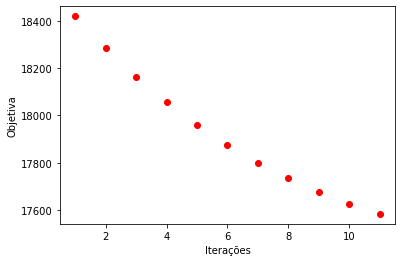

In [364]:
x_val = range(1, len(mult.loss_values)+1);
y_val = mult.loss_values;

#plt.plot(x_val,y_val)
plt.plot(x_val,y_val,'or')
plt.xlabel('Iterações')
plt.ylabel('Objetiva')
plt.show()

In [365]:
k = np.argmin(mult.loss_values)
print(k)

10


In [366]:
#optimal_weightsGD = mult.weight_list[k];
#optimal_biasGD = mult.bias_list[k];

#### Treino até a convergência

In [375]:
# Simplificação da nomenclatura
mult = mult_logistic_regression()
mult.learn_rate = 0.001;
mult.n_iter = 50;

# Treino utilizando GD
start = time.perf_counter()
#mult.trainGD(nom_X,nom_y)
end = time.perf_counter()

First stop: 4.745308899997326
Second stop: 16.428427899998496
Third stop: 15.402171699999599
0 Gradients (b,w):  1.0068161582221791e-16 , 0.13521243541396938 Loss:  17582.126904063698
First stop: 9.567182799997681
Second stop: 20.952126999996835
Third stop: 27.17558939999435
1 Gradients (b,w):  9.711762644082355e-17 , 0.13162883193927424 Loss:  17452.49120211064
First stop: 11.192668000003323
Second stop: 20.367903799997293
Third stop: 23.02691600000253
2 Gradients (b,w):  9.663602383580549e-17 , 0.13081893814125417 Loss:  17385.401471009947
First stop: 10.03646199999639
Second stop: 22.949639600003138
Third stop: 22.148543200004497
3 Gradients (b,w):  9.89987172100859e-17 , 0.13043848001349662 Loss:  17336.872445004243
First stop: 9.297964900004445
Second stop: 20.77465680000023
Third stop: 23.632136599997466
4 Gradients (b,w):  9.687162096788659e-17 , 0.1301854772562005 Loss:  17297.863743157144
First stop: 11.541978000001109
Second stop: 22.900284600000305
Third stop: 25.42457100000

In [378]:
# Lista de predições
#predictions = mult.predict(nom_Xtest);

correct = sum([t == p for t, p in zip(nom_ytest, predictions)])
accuracy = correct / len(predictions)

#print(f"Accuracy: {accuracy}")

1478.8030846000038
Accuracy: [0.698   0.888   0.5855  0.89375 0.755   0.89975 0.87675 0.9045  0.88825
 0.9    ]


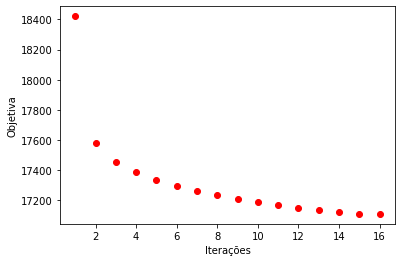

In [376]:
x_val = range(1, len(mult.loss_values)+1);
y_val = mult.loss_values;

#plt.plot(x_val,y_val)
plt.plot(x_val,y_val,'or')
plt.xlabel('Iterações')
plt.ylabel('Objetiva')
plt.show()

## 4.2. Treino com SGD

In [355]:
# Modelo com SGD. O valor inicial da taxa de aprendizado pode parecer contraditoriamente alto, mas lembra que dividimos o gradiente pelo número
# de amostras e pelo número de features. Como o gradiente do SGD é naturalmente menor do que o gradiente total porque estamos fazendo amostragens de
# menos componentes, temos que este valor mostrado foi o que mais acelerou a convergencia sem 'estourar' a rotina
#mult = mult_logistic_regression();
#mult.learn_rate = 20.0;
#mult.n_iter = 50;

# Treino utilizando SGD
start = time.perf_counter()
#mult.trainSGD(nom_X,nom_y, 64)
end = time.perf_counter()

First stop: 0.9068953999958467
Second stop: 28.896788099998957
Third stop: 16.970444300000963
0 Gradients (b,w):  1.2438834684491936e-20 , 1.6721522495858043e-05 Loss:  17902.68010227531
First stop: 6.153897199998028
Second stop: 34.57493200000317
Third stop: 50.49047520000022
1 Gradients (b,w):  1.1908442981712e-20 , 1.6715018971201673e-05 Loss:  17517.799328837187
First stop: 4.777688699999999
Second stop: 23.737357999998494
Third stop: 17.703083399996103
2 Gradients (b,w):  1.2085601616696157e-20 , 1.670364389513997e-05 Loss:  17246.62061129073
First stop: 4.401624300000549
Second stop: 25.99673310000071
Third stop: 18.706383999997342
3 Gradients (b,w):  1.211509191578773e-20 , 1.6677201677911272e-05 Loss:  17074.503874457427
First stop: 4.366539800001192
Second stop: 23.85811859999376
Third stop: 154.04992280000442
4 Gradients (b,w):  1.1932078589072168e-20 , 1.669718722493722e-05 Loss:  17074.004242706545
First stop: 7.038727600003767
Second stop: 30.121807600000466
Third stop: 36

In [356]:
# Lista de predições
#predictions = mult.predict(nom_Xtest);

correct = sum([t == p for t, p in zip(nom_ytest, predictions)])
accuracy = correct / len(predictions)

print(f"Accuracy: {accuracy}")

821.6117178000059
Accuracy: [0.73075 0.8815  0.8505  0.722   0.751   0.9     0.8865  0.9065  0.88775
 0.9    ]


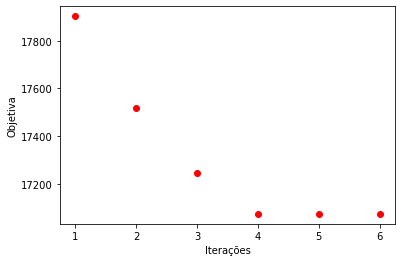

In [357]:
#x_val = range(1,len(mult.loss_values)+1);
#y_val = mult.loss_values;

#plt.plot(x_val,y_val)
plt.plot(x_val,y_val,'or')
plt.xlabel('Iterações')
plt.ylabel('Objetiva')
plt.show()

## Conclusões

Devido ao fato dos classificadores de determinados dígitos serem muito melhores de serem treinados comparados aos outros, a rotina do $\text{SGD}$ possui um desempenho geral muito superior à do $\text{GD}$, porque permite que passos intermediários não estagnem em regiões de baixo gradiente total. Isto é, sua qualidade aleatória permite uma convergência mais uniforme e rápida.